
### <font color="Red" size="6"> Juan Esteban Moreno Agudelo</font>


In [ ]:
!pip install pyomo

     |████████████████████████████████| 9.5MB 7.5MB/s 
     |████████████████████████████████| 256kB 37.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 163kB 43.7MB/s 


In [ ]:
import pandas as pd
import numpy as np 
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus,TerminationCondition
import scipy.stats as sts
from scipy.stats import uniform, norm
from scipy.stats import randint 

In [ ]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})


#***Generación de distribuciones***

In [ ]:
# Uniforme
samples = 3000
demanda_uniforme = list(uniform.rvs(size=samples, loc=2, scale=16, random_state=2))
not_repDunif = list(set(demanda_uniforme))
o_unif = np.array([demanda_uniforme.count(value) for value in not_repDunif])
pmf = o_unif/len(demanda_uniforme)

# Normal
demanda_normal = list(norm.rvs(size=samples,loc=10,scale=3, random_state=2))
# not_repDnorm = list(set(demanda_normal))
# o_norm = np.array([demanda_normal.count(value) for value in not_repDnorm])
o_norm,_,__ = plt.hist(demanda_normal, samples)
plt.close()
pmf_norm = o_norm/len(demanda_normal)

In [ ]:
sum(pmf_norm)

0.9999999999999972

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frecuencia'), Text(0.5, 0, 'Distribución normal ')]

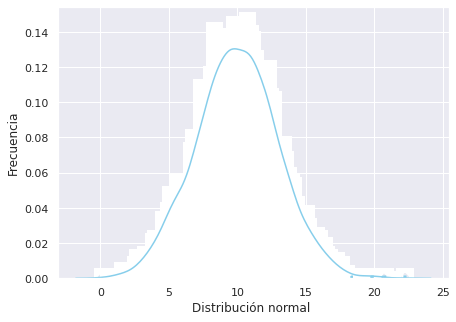

In [ ]:
ax = sns.distplot(demanda_normal,
                  bins=120,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Distribución normal ', ylabel='Frecuencia')

In [ ]:
model = pyo.ConcreteModel()
model.k = pyo.Set(initialize=list(range(samples)))

# Parámetros
model.d = pyo.Param(model.k, initialize={i: demanda_uniforme[i] for i in model.k}, mutable=True)
model.p = pyo.Param(model.k, initialize={i: pmf[i] for i in model.k}, mutable=True)
model.c = pyo.Param(initialize=3)
model.b = pyo.Param(initialize=6)
model.h = pyo.Param(initialize=2)

# Variables
model.v = pyo.Var(model.k, initialize=0)
model.x = pyo.Var(initialize=1)

def objfun(model):
    pyo.expr = sum(model.p[k]*model.v[k] for k in model.k)
    return pyo.expr
model.obj = pyo.Objective(rule=objfun, sense=pyo.minimize)

def rest1(model, k):
    return (model.c - model.b)*model.x + model.b*model.d[k] <= model.v[k]
model.r1 = pyo.Constraint(model.k, rule=rest1)

def rest2(model, k):
    return (model.c + model.h)*model.x - model.h*model.d[k] <= model.v[k]
model.r2 = pyo.Constraint(model.k, rule=rest2)


In [ ]:
# instal cbc
!apt-get install -y -qq coinor-cbc

Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unpack .../4-coinor-libcbc3_2.9.9+repack1-1_amd64.deb ...
Unpacking coinor-libcbc3 (2.9.9+repack1-1) ...
Selecting p

In [ ]:
# Chequear la solución
opt = pyo.SolverFactory("cbc", executable='/usr/bin/cbc')
results = opt.solve(model)  

# Verificación de status
if (results.solver.status == SolverStatus.ok) and \
        (results.solver.termination_condition == TerminationCondition.optimal):
    print("Solución óptima ")
    print(str(results.solver)) 
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Algo está mal..")
else:
    # algo esta mal 
    print(str(results.solver)) 

Solución óptima 

- Status: ok
  User time: -1.0
  System time: 0.71
  Wallclock time: 0.7
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created subproblems: None
    Black box: 
      Number of iterations: 4455
  Error rc: 0
  Time: 0.714134931564331



In [ ]:
print(f"(Distribución uniforme) valor óptimo para x*={round(model.x.value, 3)} \
y el valor esperado E(G(x*, D))={round(model.obj.expr(), 3)}")

(Distribución uniforme) valor óptimo para x*=7.88 y el valor esperado E(G(x*, D))=44.677


###***Cambiamos iterativamente los parámetros p y d, cambiando ya la distribución hacia una normal como se definió arriba***

In [ ]:
pmf_norm = {k: pmf_norm[k] for k in model.k}
demanda_normal = {k: demanda_normal[k] for k in model.k}
for k,value in pmf_norm.items():
    model.p[k] = value

for k,value in demanda_normal.items():
    model.d[k] = value
opt.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 38.62320413, 'Upper bound': 38.62320413, 'Number of objectives': 1, 'Number of constraints': 6001, 'Number of variables': 3002, 'Number of nonzeros': 1345, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.22, 'Wallclock time': 0.21, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 1975}}, 'Error rc': 0, 'Time': 0.23083758354187012}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
print(f"(Distribución normal) el valor óptimo x*={round(model.x.value, 3)} \
y el valor esperado E[G(x*, D)]={round(model.obj.expr(), 3)}")

(Distribución normal) el valor óptimo x*=9.014 y el valor esperado E[G(x*, D)]=38.979


### <font color="Red" size="6"> Ejercicio 3</font>
#***Worst-case***

In [ ]:
m = pyo.ConcreteModel()
m.b = pyo.Param(initialize=6)
m.c = pyo.Param(initialize=3)
m.h = pyo.Param(initialize=2)
m.u = pyo.Param(initialize=18)
m.l = pyo.Param(initialize=2)

#Limites
m.d = pyo.Var(bounds=(2, 18))
m.x = pyo.Var(domain=pyo.PositiveReals)
m.v = pyo.Var()

def obj(m):
    return m.v
m.o = pyo.Objective(rule=obj, sense=pyo.minimize)

def c1(model):
    return (m.c - m.b)*m.x + m.b*m.u <= m.v
m.c1 = pyo.Constraint(rule=c1)

def c2(model):
    return (m.c + m.h)*m.x - m.h*m.l <= m.v
m.c2 = pyo.Constraint(rule=c2)

rwc = opt.solve(m)


In [ ]:
print(f"La x* óptima es {m.x.value} y el valor esperado es {m.o.expr()}")

La x* óptima es 14.0 y el valor esperado es 66.0


####Vemos que efectivamente corresponde con los valores obtenidos en el problema 1

In [ ]:
m.x.value

14.0

In [ ]:
m.d